In [1]:
import numpy as np
from glob import glob
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
import numpy as np
from osgeo import gdal
from matplotlib import pyplot
import tifffile as tiff


#import tif for France
#image = tiff.imread("C:/Users/birgi/Desktop/Geoinformatics M.Sc/Big DAta/francesmall.tif")
#val = tiff.imread("C:/Users/birgi/Desktop/Geoinformatics M.Sc/Big DAta/france_val.tif")

#import tif for Egypt
image = tiff.imread("C:/Users/birgi/Desktop/Geoinformatics M.Sc/Big DAta/smallegypt.tif")
val = tiff.imread("C:/Users/birgi/Desktop/Geoinformatics M.Sc/Big DAta/egyptval.tif")


#covert to numpy array 
image_array = np.array(image)
val_array = np.array(val)
image.shape

(142, 148, 10)

In [4]:
class PASTISSegmentation:
    """
    Here we use a subset of the PASTIS dataset: https://github.com/VSainteuf/pastis-benchmark
    """
    def __init__(
        self,
        image_dir: str,
        annotation_dir: str,
        split:str = "train",
        binary_labels: bool = True
    ) -> None:
        
        images = glob(f"{image_dir}\\{split}/S2_*.npy")
        annotations = [] 
        for im in images:
            name = im.split('\\')[-1].replace("S2_","").replace(".npy","")
            annotations.append(f"{annotation_dir}{split}\\TARGET_{name}.npy")
        
        self.X = self.read_data(images)
        self.X = self.X[:,0] # Only keep the first date instead of 43 days

        self.y = self.read_data(annotations)
        self.y = self.y[:,0] # We are only interested in the 20 classes for now
        if binary_labels:
            self.y[self.y>0] = 1 # Convert to binary labels
        
    def __len__(self):
        return self.X.shape[0]
    
    def read_data(self, files):
        """
        Reads and stacks our data
        """
        t = []
        for im in files:
            t.append(np.load(im))
        return np.stack(t, axis=0)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def pixelwise(self):
        """
        This method flattens our images to individual pixels, so we can treat
        each pixel as a sample and train our favirote classifier on it. 
        """
        return  np.transpose(self.X, (0, 2, 3, 1)).reshape(-1, 10), self.y.reshape(-1)
    
    def pixelwise_test(self):
        """
        Short test for the above method.
        """
        N = self.__len__()
        pX, py = self.pixelwise()
        tX = np.transpose(pX.reshape(N, 128, 128, 10), (0, 3, 1, 2))
        tY = py.reshape(N, 128, 128)
        
        assert np.all(tX == self.X) and np.all(tY == self.y)
        print("All test passed!")

In [7]:
base_path = "C:/Users/birgi/Desktop/Geoinformatics M.Sc/Big DAta/data_own_w2"
p_train = PASTISSegmentation(f"{base_path}/data/images/", f"{base_path}/data/annotations/", split="train", binary_labels=True)
p_test = PASTISSegmentation(f"{base_path}/data/images/",f"{base_path}/data/annotations/", split="test", binary_labels=True)

X_train, y_train = p_train.pixelwise()
X_test = image_array.reshape(-1, image_array.shape[-1])
y_test = val_array.reshape(-1)

In [8]:
# Instead of images, we focus on the individual pixels. For each pixel, we have 10 features and a class (in y).
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((245760, 10), (245760,), (21016, 10), (21016,))

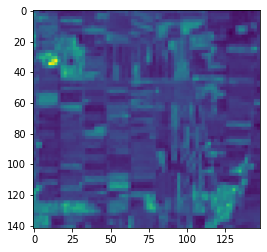

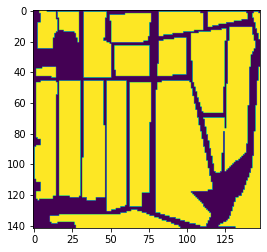

IndexError: index 1 is out of bounds for axis 0 with size 1

In [10]:
imd = 0
# Show the 7th band of the third image
plt.imshow(image[:,:,3])
plt.show()

# Show the labels for third image
plt.imshow(val)
plt.show()

p_test.X[1].shape

# Binary Classification

In [12]:
# Train a binary classifier
classifier = LogisticRegression(random_state=0, solver="saga").fit(X_train, y_train)


In [13]:
def get_positive_class_probabilities(clf, data):
    pb = clf.predict_proba(data)
    assert pb.shape[1] == 2, "The classifier predicts more than 2 classes."
    return pb[:,1]
    
X_test.shape

(21016, 10)

In [14]:
y_pred_prob = get_positive_class_probabilities(classifier, X_test)

Raw probabilities


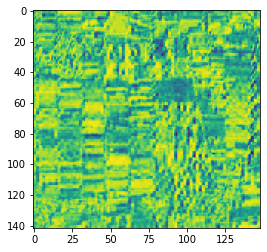

Binarized classes at threshold of 0.5


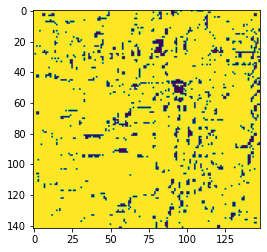

(1, 142, 148)

In [17]:
# Show prediction for one image
#tpb = y_pred_prob.copy().reshape(-1, 180, 217)# for france
tpb = y_pred_prob.copy().reshape(-1, 142, 148)# for egypt
print("Raw probabilities")
plt.imshow(tpb[imd])
plt.show()

# Binarize using a threshold of 0.5
print("Binarized classes at threshold of 0.5")
tpb[tpb >= 0.5] = 1
tpb[tpb < 0.5] = 0
plt.imshow(tpb[imd])
plt.show()

tpb.shape

In [18]:
##### Task 2a: Plot the confusion matrix of the given method at a probability cutoff of 0.5
def confusion_matrix(y_pred_prob, y_test, cutoff=0.5):
    cm = sklearn.metrics.confusion_matrix(
        y_true=y_test, 
        y_pred=y_pred_prob>=cutoff)
    return cm


cm = confusion_matrix(y_pred_prob, y_test, cutoff=0.5)
print(cm)

[[    0     0     0]
 [  429  5315     0]
 [ 1183 14089     0]]


In [82]:
# Task 2b-2d Accuracy, precision and recall

def accuracy(y_pred_prob, y_test, cutoff=0.5):
    acc = sklearn.metrics.accuracy_score(
        y_true=y_test, 
        y_pred=y_pred_prob>=cutoff)
    return acc

def recall(y_pred_prob, y_test, cutoff=0.5):
    recall = sklearn.metrics.recall_score(
        y_true=y_test, 
        y_pred=y_pred_prob>=cutoff)
    return recall

def precision(y_pred_prob, y_test, cutoff=0.5):
    precision = sklearn.metrics.precision_score(
        y_true=y_test, 
        y_pred=y_pred_prob>=cutoff)
    return precision

def iou(y_pred_prob, y_test, cutoff=0.5):
    iou = sklearn.metrics.jaccard_score(
        y_true=y_test, 
        y_pred=y_pred_prob>=cutoff)
    return iou
    
def binary_cross_entropy(y_pred_prob, y_test):
    bce = sklearn.metrics.log_loss(
        y_true=y_test, 
        y_pred=y_pred_prob)
    return bce


array([], shape=(0, 3), dtype=float64)

In [81]:
# What is the accuracy, precision and recall of the given method at a probability cutoff of 0.5?

print('acc 0.5:', accuracy(cm))
print('precision 0.5:', precision(cm))
print('recall 0.5:', recall(cm))
print('')



acc 0.5: []
precision 0.5: []
recall 0.5: []

